In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os # 因為要建立資料夾
from tensorflow.keras.models import Sequential # CNN 建立空模函式
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D # CNN 函式
from tensorflow.python.keras.utils import np_utils # 層

In [2]:
# 掛載雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 訓練資料

In [4]:
import os
path = '/content/drive/MyDrive/2023聯成電腦/Python IV 視覺辨識與機器學習/project/photos/train'
files = os.listdir(path)
directories = list()

In [5]:
for dir in files:
  if os.path.isdir(os.path.join(path, dir)):
    directories.append(dir)
directories

['絲瓜', '苦瓜', '哈密瓜', '木瓜', '冬瓜', '瓠瓜', '小黃瓜', '櫛瓜', '南瓜', '西瓜']

In [6]:
def resizeFile(dir_path, img_files): # dir_path 某個水果資料夾 img_files 資料夾中的所有檔案
  size = (250, 250)
  for item in img_files:

    item = os.path.join(dir_path, item)

    images = cv2.imread(item)
    # :2 兩通道
    h, w = images.shape[:2]
    # 找最大邊
    if h > size[0] or w > size[1]:
      # 找出最大比例 => 等比例縮小
      ratio = max(h/size[0], w/size[1])
      images = cv2.resize(images, (int(w/ratio), int(h/ratio)))
      # 重新抓取新的寬、高
    h, w = images.shape[:2]
    # 高度的黑邊
    pad_h = size[0]-h
    # 寬度的黑邊
    pad_w = size[1]-w
    # 上、下補黑邊的高度
    top, bottom = pad_h//2, pad_h-(pad_h//2)
    # 左、右補黑邊的寬度
    left, right = pad_w//2, pad_w-(pad_w//2)
    # 補黑邊(填充：適用於圖片縮小時)
    images = cv2.copyMakeBorder(images, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    # 抓檔名
    name = item.split('/')[-1]
    # 用程式判斷是否有所需的資料夾

    cv2.imwrite(f"{dir_path}/resize/{name}", images)

In [7]:
x_train = list()
y_train = list()

def create_data(path, category):
  for p in os.listdir(path):
    # 轉灰階
    img_array = cv2.imread(os.path.join(path, p), 0)
    # 訓練題目
    x_train.append(img_array)
    # 訓練答案
    y_train.append(category)

In [8]:
category = 0
for directory in directories:
  dir_path = os.path.join(path, directory)
  # 目錄中的所有檔案
  dir_file = os.listdir(dir_path)
  img_files = list()
  for file in dir_file:
    # 如附檔名為這三種的任何一種
    if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
      img_files.append(file)
  resizeDir = os.path.join(dir_path, 'resize')
  if not os.path.exists(resizeDir):
    os.makedirs(resizeDir)
    resizeFile(dir_path, img_files)
  # 分類
  create_data(resizeDir, category)
  category += 1


In [9]:
len(x_train)

1193

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
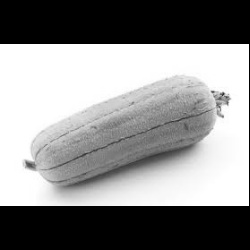

In [10]:
x_train[0]

# 測試資料

In [11]:
import os
test_path = '/content/drive/MyDrive/2023聯成電腦/Python IV 視覺辨識與機器學習/project/photos/test'
test_files = os.listdir(test_path)
test_directories = list()

In [12]:
for dir in test_files:
  if os.path.isdir(os.path.join(test_path, dir)):
    test_directories.append(dir)
test_directories

['絲瓜', '哈密瓜', '西瓜', '冬瓜', '苦瓜', '小黃瓜', '櫛瓜', '瓠瓜', '南瓜', '木瓜']

In [13]:
x_test = list()
y_test = list()

def create_testdata(path, category):
  for p in os.listdir(path):
    # 轉灰階
    img_array = cv2.imread(os.path.join(path, p), 0)
    # 訓練題目
    x_test.append(img_array)
    # 訓練答案
    y_test.append(category)

In [14]:
test_category = 0
for directory in test_directories:
  dir_path = os.path.join(test_path, directory)
  # 目錄中的所有檔案
  dir_file = os.listdir(dir_path)
  img_files = list()
  for file in dir_file:
    # 如附檔名為這三種的任何一種
    if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
      img_files.append(file)
  resizeDir = os.path.join(dir_path, 'resize')
  if not os.path.exists(resizeDir):
    os.makedirs(resizeDir)
    resizeFile(dir_path, img_files)
  # 分類
  create_testdata(resizeDir, test_category)
  test_category += 1

# 打散成組的資料

In [15]:
x_train = np.array(x_train).reshape(-1,250,250,1) # (張數, 長, 寬, 通道數)
y_train = np.array(y_train)

x_train = x_train / 255 # 色階 => 收斂
# 將答案分類 OneHot
y_train = np_utils.to_categorical(y_train)

x_test = np.array(x_test).reshape(-1,250,250,1)
y_test = np.array(y_test)

x_test = x_test / 255
y_test = np_utils.to_categorical(y_test)

In [16]:
from sklearn.model_selection import train_test_split
# 訓練
rX_train, rX_test, ry_train, ry_test = train_test_split(x_train, y_train, test_size=1, random_state=1)
# 測試
raX_train, raX_test, ray_train, ray_test = train_test_split(x_test, y_test, test_size=1, random_state=1)

# 打亂資料群

# 建模

In [28]:
model = Sequential()

In [29]:
# 卷積
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
# 池化
model.add(MaxPooling2D(pool_size=(2,2))) # pool_size=(2,2) 為預設，不寫也可以
# 卷積
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
# 池化
model.add(MaxPooling2D(pool_size=(2,2)))
# 卷積
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
# 池化
model.add(MaxPooling2D(pool_size=(2,2)))
# 放棄的比率
model.add(Dropout(0.3))
# 扁平化
model.add(Flatten())
# 放棄的比率
model.add(Dropout(0.2))
# 連接層：通常用1024(三通道 32*32*32)
model.add(Dense(1024, activation='relu'))
# 輸出層：10種分類
model.add(Dense(10, activation='softmax'))

# 編譯(程式)

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練

In [33]:
model.fit(rX_train, ry_train, epochs=15, batch_size=30, validation_data=(x_test, y_test))

Epoch 1/15
40/40 [==============================] - 62s 188ms/step - loss: 0.4160 - accuracy: 0.1359 - val_loss: 0.3476 - val_accuracy: 0.1497
Epoch 2/15
40/40 [==============================] - 5s 122ms/step - loss: 0.3024 - accuracy: 0.2273 - val_loss: 0.3731 - val_accuracy: 0.0986
Epoch 3/15
40/40 [==============================] - 5s 123ms/step - loss: 0.2784 - accuracy: 0.3440 - val_loss: 0.3839 - val_accuracy: 0.0476
Epoch 4/15
40/40 [==============================] - 5s 129ms/step - loss: 0.2359 - accuracy: 0.4832 - val_loss: 0.4231 - val_accuracy: 0.1599
Epoch 5/15
40/40 [==============================] - 5s 124ms/step - loss: 0.1830 - accuracy: 0.6426 - val_loss: 0.4820 - val_accuracy: 0.1463
Epoch 6/15
40/40 [==============================] - 5s 130ms/step - loss: 0.1232 - accuracy: 0.7777 - val_loss: 0.5405 - val_accuracy: 0.1837
Epoch 7/15
40/40 [==============================] - 5s 128ms/step - loss: 0.0800 - accuracy: 0.8834 - val_loss: 0.7266 - val_accuracy: 0.2007
Epoch

# 測試

In [34]:
predict1 = model.predict(rX_train)

38/38 [==============================] - 2s 22ms/step


In [35]:
predict2 = model.predict(raX_train)

10/10 [==============================] - 1s 52ms/step


In [36]:
right = 0
for i in range(len(predict1)):
  ans = np.argmax(predict1[i])
  pre = ry_train[i][ans]
  if pre == 1:
    right += 1
right / len(predict1)

1.0

In [37]:
right = 0
for i in range(len(predict2)):
  ans = np.argmax(predict2[i])
  pre = ray_train[i][ans]
  if pre == 1:
    right += 1
right / len(predict2)

0.1945392491467577